In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

import spacy
from scipy.sparse import hstack
import matplotlib.pyplot as plt


In [5]:
import re
import unicodedata

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Normalize unicode characters
    text = unicodedata.normalize("NFKC", text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove special characters (optional)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    return text
    
def load_data(file): 
    return pd.read_csv(file, names=['id', 'entity', 'label', 'text']).set_index('id')

def clean_data(df): 
    return df.drop_duplicates().dropna()

def drop_label(df): 
    return df[df['label'].isin({'Positive','Negative'})]

label_encoder = LabelBinarizer()
def preprocess(df, training): 
    if training: 
        df['label_num'] = label_encoder.fit_transform(df['label'])
    else: 
        df['label_num'] = label_encoder.transform(df['label'])
    df['text_processed'] = df['text'].apply(preprocess_text)
    return clean_data(df)

In [6]:
training_df = load_data("~/sentiment_analysis/archive/twitter_training.csv")
training_df = drop_label(clean_data(training_df))
training_df = preprocess(training_df, training=True)

In [7]:
test_df = load_data("~/sentiment_analysis/archive/twitter_validation.csv")
test_df = drop_label(clean_data(test_df))
test_df = preprocess(test_df, training=False)

In [9]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = SentenceTransformer('all-MiniLM-L6-v2')
X_train = model.encode(training_df["text_processed"].tolist()) 
X_test = model.encode(test_df["text_processed"].tolist()) 

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
len(X_train)

41114

In [18]:
len(X_train[0])

384

In [10]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC(),
}
for model in models.values():
    model.fit(X_train, training_df['label_num']) 

In [11]:
def get_stats_from_library(y_prob, label): 
    fprs, tprs, _ = roc_curve(label, y_prob)
    auc = roc_auc_score(label, y_prob)
    return fprs, tprs, auc
    
def display_roc_auc(y_probs, models, func):  
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    colors = ["blue", "red"]
    i = 0
    for name in models:
        y_prob = y_probs[name]
        fprs, tprs, auc = func(y_prob, test_df['label_num'])
        plt.plot(fprs, tprs, label=f"{name} AUC = {auc:.4f}", color=colors[i])
        i+=1
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [19]:
y_probs = {}
y_predicts = {}
for name, model in models.items():
    training_score = model.score(X_train, training_df['label_num'])
    testing_score = model.score(X_test, test_df['label_num'])
    print(f"{name} training score (bias): {training_score * 100:.2f} ; testing score (variance):  {testing_score * 100:.2f}")
    
    y_probs[name] = model._predict_proba_lr(X_test)[:, 1]
    y_predicts[name] = model.predict(X_test)

LogisticRegression training score (bias): 83.82 ; testing score (variance):  86.00
SVM training score (bias): 83.96 ; testing score (variance):  86.00


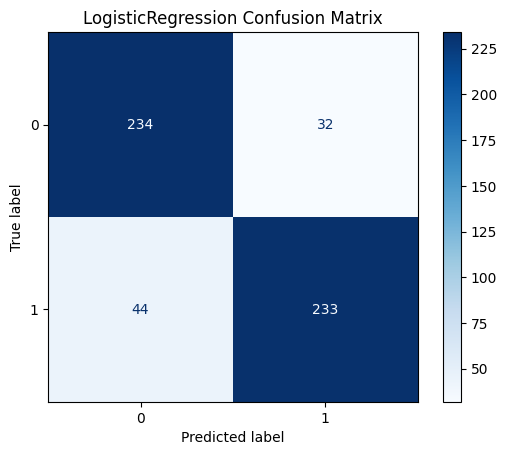

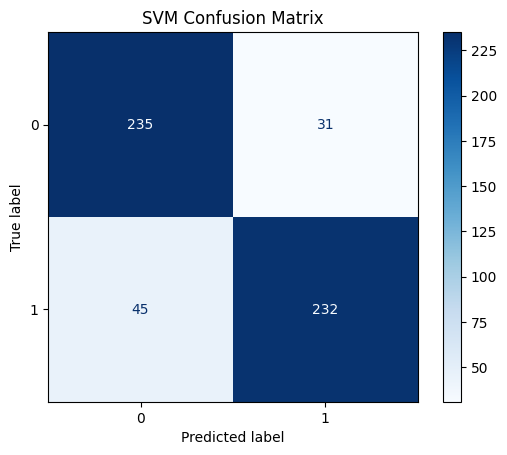

In [20]:
for name in models: 
    y_true = test_df['label_num']
    y_pred = y_predicts[name]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

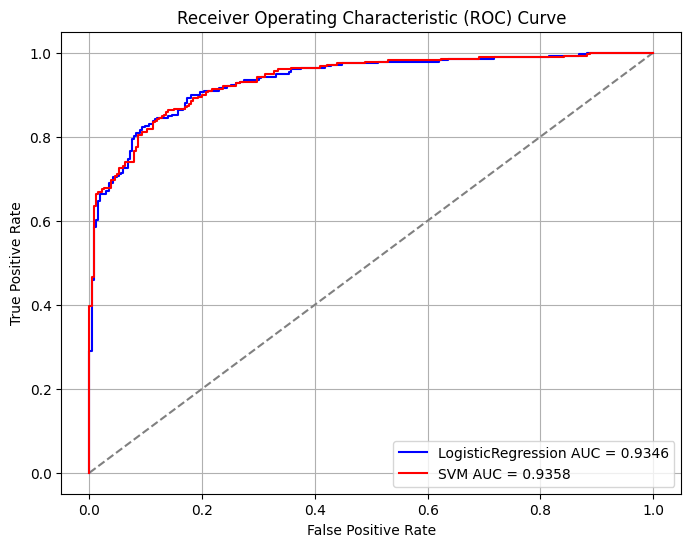

In [21]:
display_roc_auc(y_probs, models, get_stats_from_library)